In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(1)

## Loading the datasets, i.e loading frames for few actions

In [3]:
#loading and prepping data
#initially only one action
dframe = pd.read_csv('./csv_data/action_1.csv')
dframe2 = pd.read_csv('./csv_data/action_2.csv')
dframe3 = pd.read_csv('./csv_data/action_3.csv')

#to look at data
dframe.iloc[0:5, :]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,label,id,video_id
0,-0.382997,-0.419442,3.449989,-0.366909,-0.092619,3.443680,-0.353380,0.229542,3.427116,-0.391862,...,3.636719,-0.435790,-0.536338,3.280097,-0.364369,-0.491436,3.269750,1,72057594037944340,0
1,-0.383146,-0.419292,3.450006,-0.367569,-0.092003,3.443895,-0.353885,0.230300,3.427162,-0.391820,...,3.633053,-0.436031,-0.536649,3.281972,-0.358806,-0.471054,3.269975,1,72057594037944340,0
2,-0.385776,-0.421191,3.449611,-0.369506,-0.092775,3.443796,-0.354571,0.230189,3.426965,-0.403822,...,3.632370,-0.436489,-0.536484,3.286322,-0.358079,-0.470344,3.270202,1,72057594037944340,0
3,-0.385807,-0.421205,3.449582,-0.369576,-0.092714,3.443878,-0.354524,0.230369,3.427140,-0.403580,...,3.499778,-0.441701,-0.533234,3.278971,-0.360298,-0.476572,3.268953,1,72057594037944340,0
4,-0.357840,-0.420304,3.438846,-0.364956,-0.092426,3.442334,-0.354907,0.230391,3.427352,-0.405945,...,3.400878,-0.430001,-0.536492,3.278641,-0.358697,-0.471415,3.270685,1,72057594037944340,0


## Some utility functions to split the datasets and loading the datasets in batch

In [6]:
#making test and train split
def train_test_split(dframe_list):
    train_split = np.empty(0, dtype=object)
    test_split = np.empty(0, dtype=object)
    for dframe in dframe_list:
        label = dframe.iloc[0,75]
        num_samples = len(dframe.iloc[:,:])
        video_ids = np.unique(dframe.iloc[:,-1].values)
        train_video_ids = video_ids[:-15]
        test_video_ids = video_ids[-15:]
        train_split1 = np.empty(len(train_video_ids), dtype=object)
        test_split1 = np.empty(len(test_video_ids), dtype=object)

        for idx,i in enumerate(train_video_ids):
            train_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            mean_vec = np.mean(train_split1[idx], axis=0)
            std_vec = np.std(train_split1[idx], axis=0)
            train_split1[idx] = ((train_split1[idx] - mean_vec)/std_vec, label)

        for idx,i in enumerate(test_video_ids):
            test_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            mean_vec = np.mean(test_split1[idx], axis=0)
            std_vec = np.std(test_split1[idx], axis=0)
            test_split1[idx] = ((test_split1[idx] - mean_vec)/std_vec, label)
        train_split = np.concatenate((train_split, train_split1))
        test_split = np.concatenate((test_split, test_split1))
    
    return train_split, test_split
    #print(train_split[0])
train_split, test_split = train_test_split([dframe, dframe2, dframe3])

#looking at split
train_split[0:3]

array([ (array([[ 0.00350941,  0.84391537,  0.701554  , ...,  0.78419412,
        -1.3888705 ,  0.17664693],
       [-0.00386702,  0.86154336,  0.70382914, ...,  0.91561407,
        -0.6524601 ,  0.18841006],
       [-0.13365281,  0.63831421,  0.65096565, ...,  0.93279967,
        -0.62680288,  0.20027775],
       ..., 
       [-0.35679119,  1.26618806,  0.53868094, ..., -1.1590611 ,
         0.93037134,  0.42435224],
       [-0.37398149,  1.06508792, -0.2482489 , ..., -1.16382884,
         0.69447374,  0.26578529],
       [-0.28683101,  1.01082895, -0.00628136, ..., -1.11628139,
         1.03893309,  0.31869323]]), 1),
       (array([[ 2.78371373,  0.7131016 ,  1.95213024, ..., -1.39477365,
        -2.52705973,  2.77899699],
       [ 2.76726734,  0.69431908,  1.922953  , ...,  1.26127291,
        -2.65949203,  3.06380966],
       [ 2.57730803,  0.71287038,  1.86510157, ...,  0.66255685,
        -2.66238735,  2.9398588 ],
       ..., 
       [-0.07787277,  1.57086147, -0.81417427, ...,

In [7]:
def Data_gen( train_split, SEQ_LEN):
    while(True):
        X = train_split
        databatch = random.sample(list(X), 1)[0]
        databatch, label = databatch[0], databatch[1]
        if len(databatch) > SEQ_LEN:
            databatch = databatch[0:SEQ_LEN]
        elif len(databatch) < SEQ_LEN:
            databatch = np.concatenate((databatch, np.zeros((SEQ_LEN - len(databatch), 75))))
        else:
            pass
        yield databatch,label

ACTd = Data_gen(train_split, 120)

#to look at batch created by Actd
next(ACTd)

(array([[-1.8598753 , -2.14005396, -3.6418167 , ..., -0.37516055,
         -2.76462376,  1.77888567],
        [-1.89802004, -2.74001249, -3.3323442 , ..., -3.16328678,
         -2.25436534,  0.91493984],
        [-1.85269063, -3.07463375, -2.87758499, ..., -2.97224757,
         -3.31209808,  0.85272389],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]), 1)

## LSTM Classifier model defination and intialisation

In [16]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(joints_dim, hidden_dim, num_layers=2)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(120, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(120, self.batch_size, self.hidden_dim)))

    def forward(self, joints3d_vec):
        x = joints3d_vec
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y, dim=1)
        return log_probs

#instanstiating a model
model0 = LSTMClassifier(75, 75, 10, 1)

## Training the model

In [10]:
def evaluate_accuracy(model, test_split):
    pred_labels = np.empty(len(test_split))
    orig_labels = np.array([t[1] for t in test_split])
    for i in range(len(test_split)):
        d_in = autograd.Variable(torch.from_numpy(test_split[i][0]).float())
        y_pred = model(d_in)
        pred_labels[i] = y_pred.data.max(1)[1].numpy()[0];
    n_samples = len(pred_labels)
    res=(orig_labels==pred_labels)
    correct_count = (res==True).sum()
    return (correct_count*100/n_samples)

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :2.30187
epoch: 0 iterations: 100 loss :2.17643
epoch: 0 iterations: 200 loss :1.93539
epoch: 0 iterations: 300 loss :1.13507
epoch: 0 iterations: 400 loss :1.22679
epoch: 0 <====train track===> avg_loss: 0.013473371750116349, accuracy: 35.55555555555556% 

epoch 1 starting ...
epoch: 1 iterations: 0 loss :1.46647
epoch: 1 iterations: 100 loss :1.30649
epoch: 1 iterations: 200 loss :1.30978
epoch: 1 iterations: 300 loss :1.20439
epoch: 1 iterations: 400 loss :1.14777
epoch: 1 <====train track===> avg_loss: 0.009417644673585891, accuracy: 37.77777777777778% 

epoch 2 starting ...
epoch: 2 iterations: 0 loss :1.1333
epoch: 2 iterations: 100 loss :1.07064
epoch: 2 iterations: 200 loss :0.987345
epoch: 2 iterations: 300 loss :1.1552
epoch: 2 iterations: 400 loss :1.14859
epoch: 2 <====train track===> avg_loss: 0.009243977641065916, accuracy: 33.333333333333336% 

epoch 3 starting ...
epoch: 3 iterations: 0 loss :1.1

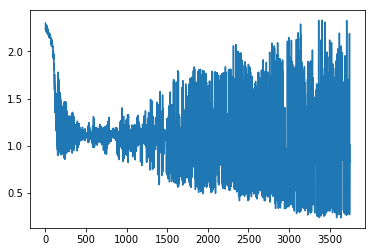

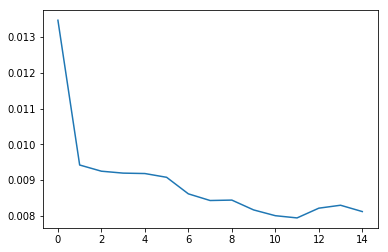

In [17]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        for i in range(num_iter):
            model.hidden = (model.hidden[0].detach(), model.hidden[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float())
            Y = autograd.Variable(torch.LongTensor(np.array([Y])))

            y_hat = model(X)       
            loss = F.cross_entropy(y_hat, Y)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
        acc = evaluate_accuracy(model, test_split)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 15, 500, 2, 100)
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)